# Water flow controller

Example of a water control system adapted from ["Taming Dr. Frankenstein: Contract-Based Design for Cyber-physical Systems"](https://doi.org/10.3166/ejc.18.217-238)

In [17]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Seafile/code/AlgebraicContracts.jl`


In [18]:
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using DifferentialEquations
using Plots
#-------
using IntervalSets  # Library is required to create intervals of real numbers
using PrettyTables
using LabelledArrays

In [19]:
# Raul fix this
include("../src/ContractMachine.jl")
# Add machine type module
using .StaticContractMachine

## Wiring diagram architecture

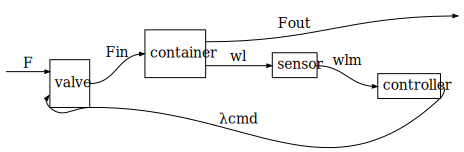

In [20]:
# Diagram:           Inputs, Outputs <- Ports of entire diagram
water_flow = WiringDiagram([:F], [:Fout])

# add boxes to diagram
valve      = add_box!(water_flow, Box(:valve,     [:F, :λcmd], [:Fin]) )
container  = add_box!(water_flow, Box(:container, [:Fin],      [:Fout, :wl]) )
sensor     = add_box!(water_flow, Box(:sensor,    [:wl],       [:wlm]) )
controller = add_box!(water_flow, Box(:controller,[:wlm],      [:λcmd]) )

# add connections
add_wires!(water_flow, [
    # Net Inputs      
    (input_id(water_flow),1) => (valve,1),
    # Connections
    (valve, 1) => (container, 1),
    (container, 2) => (sensor, 1),
    (sensor, 1) => (controller, 1),
    (controller, 1) => (valve, 2),
    # Net Outputs
    (container,1) => (output_id(water_flow),1)
])

to_graphviz(water_flow, orientation=LeftToRight, labels=true)

## Wiring diagram semantics

In [21]:
# Dynamics functions of each box
function dynamics_valve(u,x,p,t)
    u = @LArray u (:λ, :Fin) 
    x = @LArray x (:F, :λcmd) 
    return [ (x.λcmd - u.λ) * 0.5, 
             x.F*(0.2*u.λ^2 + 0.8*u.λ) ]
end

function dynamics_container(u,x,p,t)
    u = @LArray u (:wl,) 
    x = @LArray x (:Fin,)
    wl = u.wl <= 0 ? 0 : p.Sout*( 2*p.g*u.wl )^0.5
    return [ (x.Fin - wl)/( pi*(p.d/2)^2 ) ]  
end

function dynamics_sensor(u,x,p,t)
    u = @LArray u (:wlm,)
    x = @LArray x (:wl,)
    return [ (x.wl - u.wlm)*p.ks ]
end

function dynamics_controller(u,x,p,t)
    u = @LArray u (:λcmd,)
    x = @LArray x (:wlm,)
    λt = (p.wlmax - x.wlm)/(p.wlmax - p.wlmin)
    λt = λt < 0 ? 0 : 
         λt > 1 ? 1 : λt
    return [ (λt - u.λcmd)*p.kc ]
end

# Readout function of each box
function readout_valve(u, p, t)
    u = @LArray u (:λ, :Fin)
    return return [u.Fin]
end

function readout_container(u, p, t) 
    u = @LArray u (:wl,)
    p = pvalve
    fout = u.wl < 0 ? 0 : p.Sout*( 2*p.g*u.wl )^0.5  # need to modify static contracts to accept parameters.
    return [fout, u.wl]
end

readout_sensor(u, p, t) = u
readout_controller(u, p, t) = u

readout_controller (generic function with 1 method)

In [22]:
# Initial conditions
u_init = LVector(λ = 0.0,   # valve position [0, 1]
                Fin = 0.0,  # flow rate past valve
                wl = 0.0,   # water level in container
                wlm = 0.0,  # measured water level
                λcmd = 0.0) # commanded valve position [sent by controller]

# NOTE: The container must drain faster than the input flow fills it. 
pvalve = LVector(Sout = 0.1, # Exit area of container | | m^2
                g = 9.8,     # Acceleration due to gravity | m/s^2
                d = 1.0,     # Diameter of container | m
                wlmax = 0.5, # maximum water level | m
                wlmin = 0.4, # minimum water level | m
                ks = 1.0,    # time constant of sensor, 1rst order
                kc = 0.5)    # time constant of controller, 1rst order

x_init = LVector(F = 0.005) # Input flow rate | m^3/s

# Integration span must be large enough to see steady state behavior
tspan = (0.0, 200.0)

(0.0, 200.0)

In [23]:
# Input and output contracts [assume, guarentee] of each box and each port
sensor_in = [ OpenInterval(0.1..0.6) ]
sensor_out = [ (0.95*pvalve.wlmin)..(1.05*pvalve.wlmax) ]

control_in = [-Inf..Inf]
control_out = [ OpenInterval(0.0..1.0) ]

container_in = [ OpenInterval(0.0..20.0) ]
container_out = [ OpenInterval(0.01..20.0), pvalve.wlmin..pvalve.wlmax ]

valve_in = [ OpenInterval(0.0..10.0), 0.0..1.0]
valve_out = [ OpenInterval(0.0..10.0) ] 

1-element Vector{OpenInterval{Float64}}:
 0.0..10.0 (open)

In [24]:
# Creating atomic contract machines
valve_machine      = ContractMachine{Float64}(valve_in, 2, valve_out,     
                                                            dynamics_valve, 
                                                            readout_valve)

container_machine  = ContractMachine{Float64}(container_in, 1, container_out, 
                                                            dynamics_container, 
                                                            readout_container)

sensor_machine     = ContractMachine{Float64}(sensor_in, 1, sensor_out,    
                                                            dynamics_sensor, 
                                                            readout_sensor)

controller_machine = ContractMachine{Float64}(control_in, 1, control_out,   
                                                            dynamics_controller, 
                                                            readout_controller)

StaticContract( ℝ × [0.0,1.0] )

In [25]:
# Compose system
water_system = oapply(water_flow, Dict( :valve => valve_machine, 
                                        :container => container_machine, 
                                        :sensor => sensor_machine, 
                                        :controller => controller_machine )) 
# need to fix show of real cross real composition

StaticContract( [0.0,10.0] × [0.01,20.0] )

In [ ]:
# Solve Dynamics. The water level should reach the desired value
prob = ODEProblem(water_system, u_init, x_init, tspan, pvalve)
sol = solve( prob, alg_hints=[:stiff] );
plot(sol)

In [ ]:
# Show when and where contracts were violated
dict = check_contract(sol, water_system, x_init, pvalve)